In [60]:
from pandas import Series
import pandas as pd
import numpy as np
import math
import warnings; warnings.simplefilter('ignore')


import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from sklearn import metrics
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from datetime import datetime
from datetime import timedelta

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/train.csv


опишем сполльзуемые функции

In [61]:
#построение графики
def get_boxplot(col):
    fig, ax = plt.subplots(figsize = (14, 10))
    sns.boxplot(y= col, data = data_train, x = 'default')
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + col)
    plt.show()

#удаление выбросов

def cut_emissions(x):
    median = x.median()
    IQR = x.quantile(0.75) - x.quantile(0.25)
    perc25 = x.quantile(0.25)
    perc75 = x.quantile(0.75)
    x = x.loc[x.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    return x


## EDA

In [62]:
data_train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')

test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')

test_cid['client_id'] = test['client_id']

In [63]:
data_train.isna().sum()
data_train.shape
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

заполним пропуски в education наиболее частым значением

In [64]:
data_train['education'] = data_train['education'].fillna( data_train['education'].value_counts().index[0])

подготовим данные для работы - сгруппируем признаки

In [65]:
num_cols = ['age', 'score_bki', 'income','decline_app_cnt','bki_request_cnt'] #числовые признаки 
num_cols_no_cut_emissions = ['age', 'score_bki', 'income','bki_request_cnt'] #числовые признаки для удаления выбросов
num_cols_log = ['age', 'income','bki_request_cnt'] #числовые признаки для сглаживания
cat_cols = ['education','region_rating','home_address','work_address','sna','first_time'] #катег признаки
bin_cols = ['good_work','sex','car','car_type','foreign_passport'] #бинарные признаки

посмотрим на распределение числовых переменных

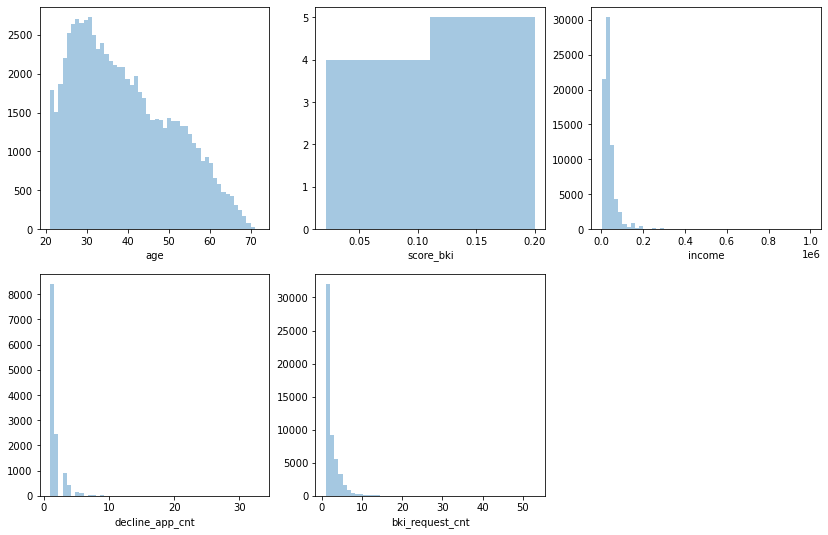

In [66]:
fig = plt.figure(figsize=(14,9) )
for j, i in enumerate(num_cols):
    ax=fig.add_subplot(2,3,j+1)
    sns.distplot(data_train[i][data_train[i] > 0].dropna(), kde = False, rug=False,ax=ax)
plt.show()

анализ графики показывает в целом на нормальное распределение числовых признаков age, score_bki, други признаки имеют существенные пики, сгладим их логарифмированием

построим  boxplot для чиловых переменных с учетом целевой переменной

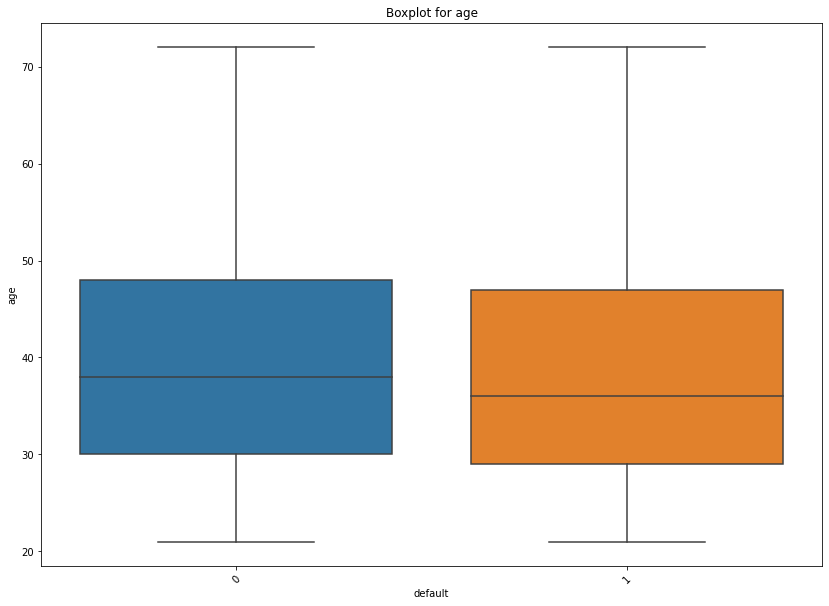

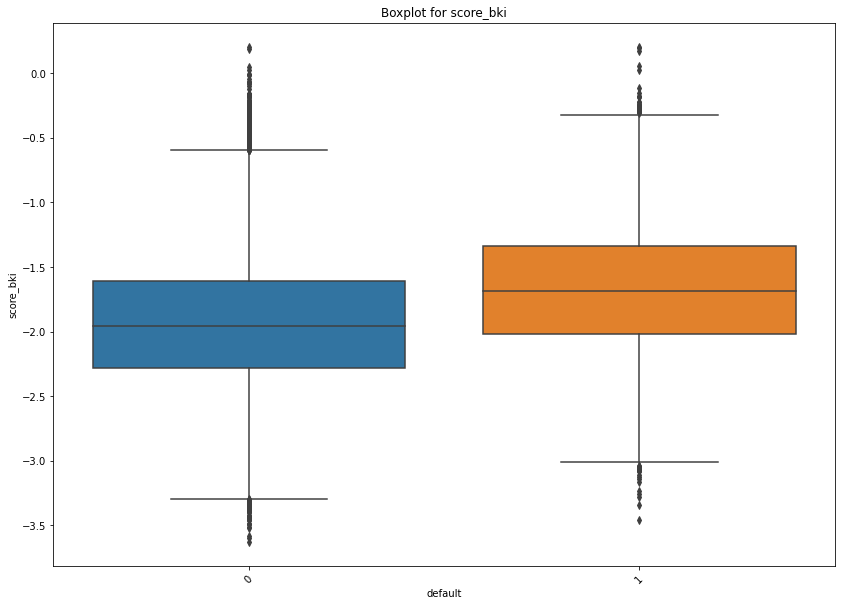

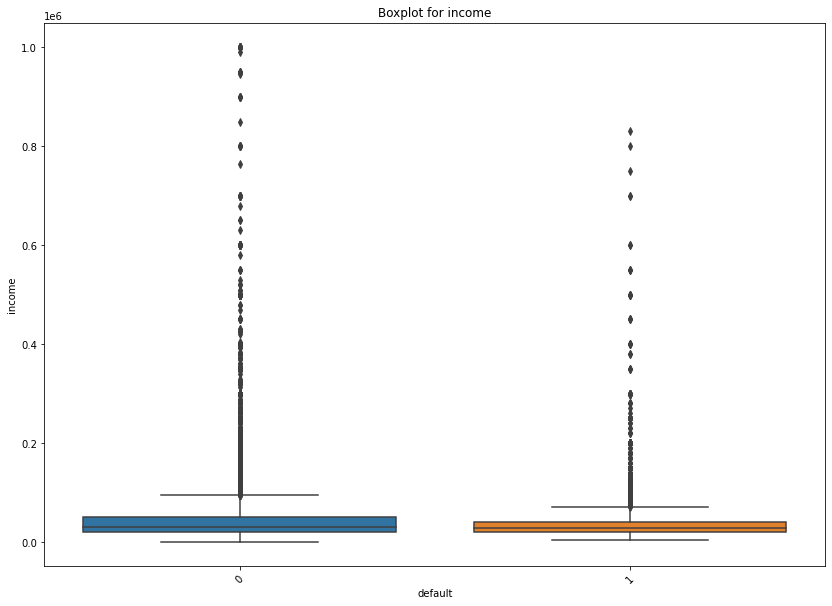

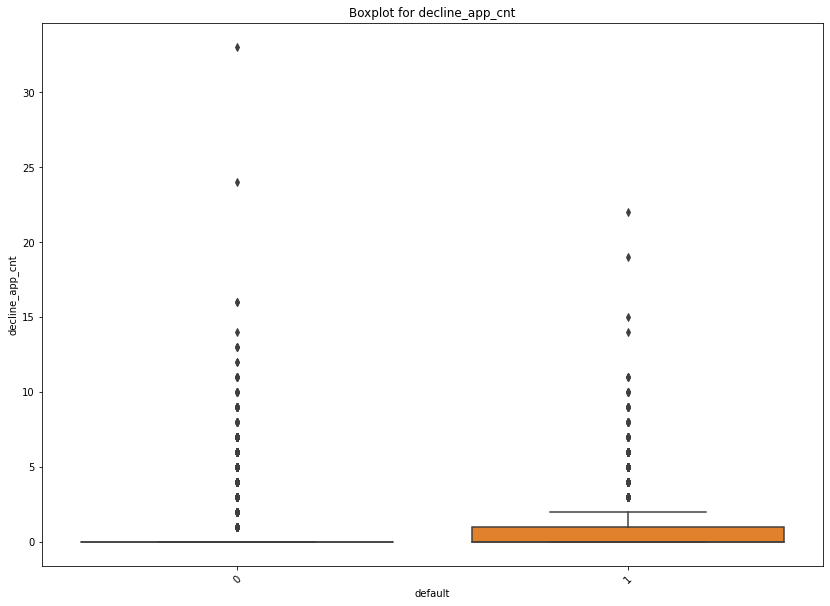

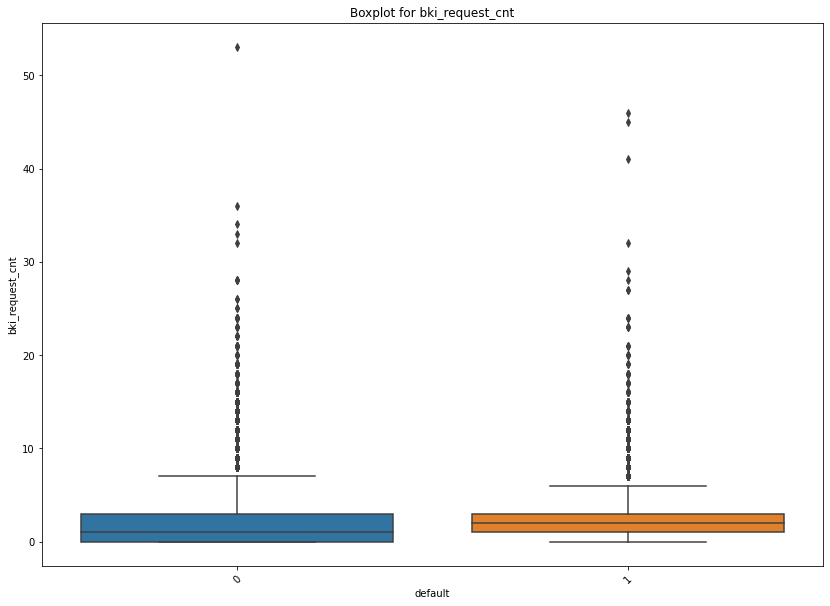

In [67]:
for col in num_cols:
    get_boxplot(col)

анализ графики показывает на наличие выбросов, а так же на зависимост целевой переменной от ряда признаков

удалим выбросы

In [68]:
data_train[num_cols_no_cut_emissions] = data_train[num_cols_no_cut_emissions].apply(lambda x: cut_emissions(x))
#заполняем полученные пропуски средним значением 
data_train = data_train.fillna(data_train.mean())

## определим значимость перменных и корреляции

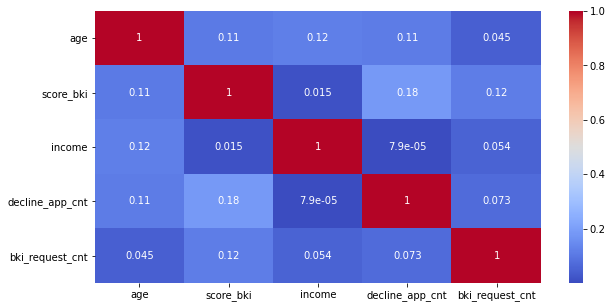

In [69]:
# начнем с числовых признаков 
# оценим корреляции
correlation = data_train[num_cols].corr().abs()
plt.rcParams['figure.figsize'] = (10,5)
sns.heatmap(correlation, annot = True, cmap = 'coolwarm')

видим, что корреляций между числовыми признаками нет

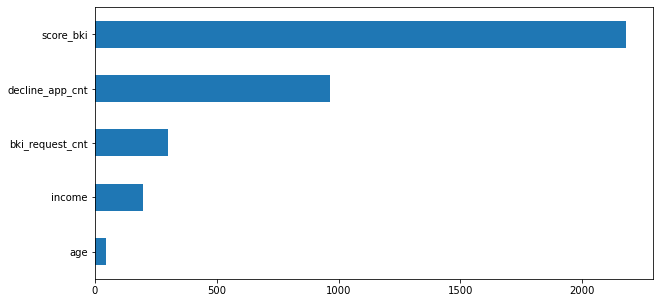

In [70]:
# оценим значимость признаков для целевой переменной
imp_num = Series(f_classif(data_train[num_cols], data_train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

видим наиболее значимый признак score_bki инаименее значимый признак age

оцифруем переменные бинарные и категориальные переменные

In [71]:
label_encoder = LabelEncoder()
for i in bin_cols:
    data_train[i] = label_encoder.fit_transform(data_train[i])

data_train['education'] = data_train.apply(lambda x: x['education'].replace('SCH', '1').replace('GRD', '2').replace('UGR', '3').replace('PGR', '4').replace('ACD', '5')
                                                if type(x['education']) == str else 6,axis = 1)

label_encoder_test = LabelEncoder()
for i in bin_cols:
    test[i] = label_encoder_test.fit_transform(test[i])

test['education'] = test.apply(lambda x: x['education'].replace('SCH', '1').replace('GRD', '2').replace('UGR', '3').replace('PGR', '4').replace('ACD', '5')
                                                if type(x['education']) == str else 6,axis = 1)

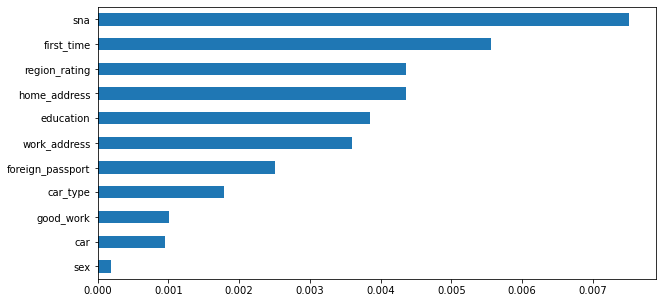

In [72]:
#поработаем с категориальными признаками, определим наболее значимые парамтры для целевой переменной

imp_cat = Series(mutual_info_classif(data_train[bin_cols + cat_cols], data_train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

## FE, нормализация

In [73]:
data_train.app_date = data_train.app_date.apply(lambda x: datetime.strptime(x, '%d%b%Y'))
data_train['dayofweek'] = data_train['app_date'].dt.dayofweek
data_train['day'] = data_train['app_date'].dt.day
data_train['month'] = data_train['app_date'].dt.month

test.app_date = test.app_date.apply(lambda x: datetime.strptime(x, '%d%b%Y'))
test['dayofweek'] = test['app_date'].dt.dayofweek
test['day'] = test['app_date'].dt.day
test['month'] = test['app_date'].dt.month

приступим к нормализации данных

In [74]:
#стандартизация
scaler_st = StandardScaler()
norm_st = scaler_st.fit_transform(data_train[num_cols])

scaler_mm = MinMaxScaler()
min_max_st = scaler_mm.fit_transform(data_train[num_cols])

#мин, макс нормализация
scaler_st_test = StandardScaler()
norm_st_test = scaler_st_test.fit_transform(test[num_cols])

scaler_mm_test = MinMaxScaler()
min_max_st_test = scaler_mm_test.fit_transform(test[num_cols])

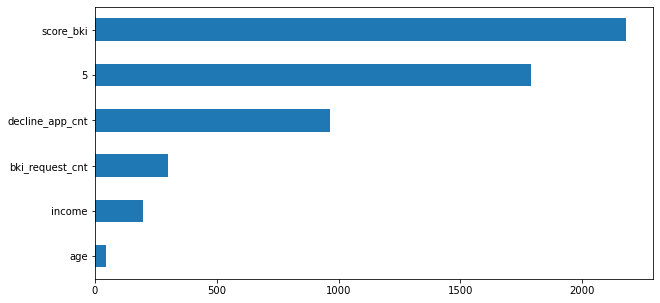

In [75]:
#Cоздадим полиномиальные признаки

pf = PolynomialFeatures(3)
polyfeatires = pf.fit_transform(data_train[['score_bki','decline_app_cnt']])[:,1:]
data_train = pd.concat([data_train, pd.DataFrame(polyfeatires)], axis=1)

pf_test = PolynomialFeatures(3)
polyfeatires_test = pf.fit_transform(test[['score_bki','decline_app_cnt']])[:,1:]
test = pd.concat([test, pd.DataFrame(polyfeatires_test)], axis=1)

#посомтрим значимость новых полученных переменных, оставим в датасете новый признак 5
num_cols1 = ['age', 'score_bki', 'income','decline_app_cnt','bki_request_cnt',5]
imp_num = Series(f_classif(data_train[num_cols1], data_train['default'])[0], index = num_cols1)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

#переименуем полученный признак
data_train['polynom_1'] = data_train[5]
test['polynom_1'] = test[5]

прологарифмируем числовые признаки

In [76]:
data_train_log = data_train[num_cols_log].apply(lambda x: np.log(x+1))
test_log = test[num_cols_log].apply(lambda x: np.log(x+1))

In [77]:
#удалим не нужные признаки
data_train = data_train.drop(columns = ['client_id', 'app_date',0,1,2,3,4,5,6,7,8])
test = test.drop(columns = ['client_id','app_date',0,1,2,3,4,5,6,7,8])

## Итак, что мы сделали:
    - заполнили пропуски;
    - удалили выбросы;
    - сгладили цифровые перменные логарифмом(data_train_log);
    - номрализовали данные(norm_st, min_max_st);
    - добавили полиномиальную переменную(['polynom_1'])
    - добавили переменные на основании даты.
Теперь соберем полученный датасет для начало работы по обучению

In [78]:
X = np.hstack([data_train.drop(columns = ['default']), data_train_log, norm_st, min_max_st])
y = data_train.default.values

test = np.hstack([test, test_log, norm_st_test, min_max_st_test])
client_id_test = test_cid['client_id']

## ML

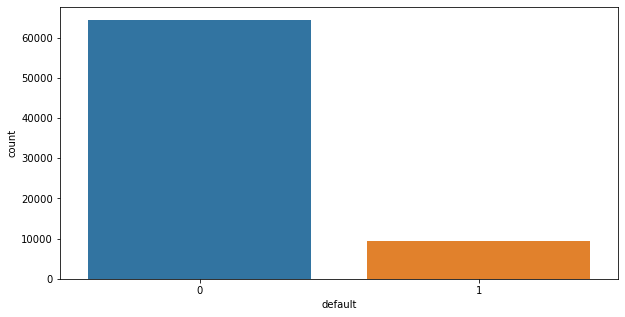

In [79]:
#проверим дисбаланс целевой переменной
sns.countplot(x='default', data=data_train)

видим заметный дисбаланс целевой переменной, поэтому попробуем применить oversampling или undersampling 

разобьем выборку

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


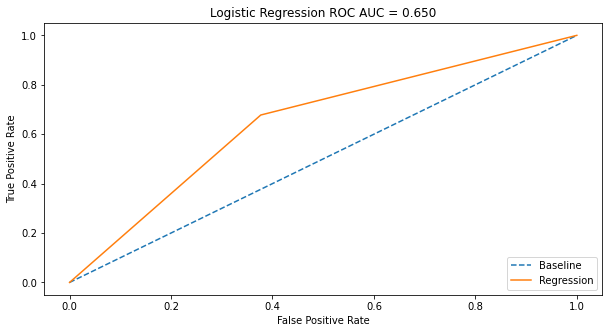

In [94]:
log_reg = sk.linear_model.LogisticRegression(max_iter=400, class_weight='balanced')
model = log_reg.fit(X_train, y_train)

y_pred = model.predict(X_test)

fpr, tpr, threshold = sk.metrics.roc_curve(y_test, y_pred)
roc_auc = sk.metrics.roc_auc_score(y_test, y_pred)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [82]:
log_reg = sk.linear_model.LogisticRegression(max_iter=400)
model_log_reg = log_reg.fit(X, y)
y_pred_probs = model_log_reg.predict_proba(test)

In [83]:
my_submission = pd.DataFrame({'client_id': client_id_test, 
                              'default': y_pred_probs[:, 1]})
my_submission.to_csv('submission.csv', index=False)

In [84]:
my_submission

,client_id,default
0,74835,0.061930
1,17527,0.293199
2,75683,0.120822
3,26883,0.104295
4,28862,0.024129
...,...,...
36344,83775,0.181049
36345,106254,0.019801
36346,81852,0.205310
36347,1971,0.186090
